(-2.0, 0.1)

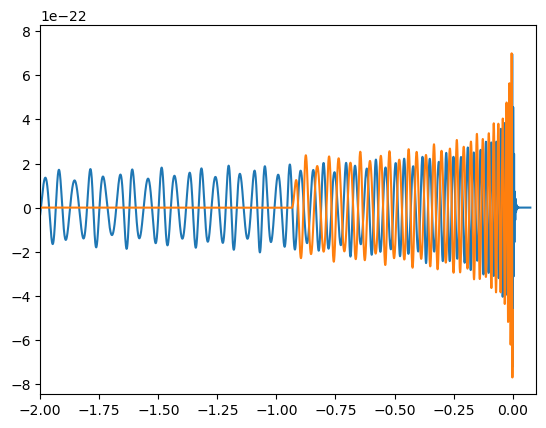

In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

directory = '/home/ben.patterson/projects/EccentricBinaries/notebooks/datafind_ecc_test/'
with open(directory+'get_injection_data_wf.pickle', 'rb') as handle:
    wf_0 = pickle.load(handle)
with open(directory+'calculate_snrs_and_sigma.pickle', 'rb') as handle:
    wf_1 = pickle.load(handle)

maxind = np.argmax(np.abs(wf_0))
plt.plot(wf_0.sample_times-wf_0.sample_times[maxind], wf_0)
plt.plot(wf_1.to_timeseries().sample_times, wf_1.to_timeseries())
plt.xlim(-2,0.1)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd as psd_func
from pycbc.filter import sigma, overlap_cplx
from simple_pe.waveforms import orthonormalize_modes, make_waveform, calculate_mode_snr
from simple_pe import io

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [21]:
# Generate psd
ifos = ['H1', 'L1', 'V1']
tlen = 64
sample_rate = 4096
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'L1': 'aLIGOZeroDetHighPower',
        'V1': 'AdVO3LowT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

# Generate harmonics
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/tlen, f_low, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=12, orthonormalize_ecc_harms=False)

# Orthonormalize
harms_harm, _, _ = orthonormalize_modes(harms, io.calculate_harmonic_mean_psd(psd), f_low, modes=[0,1,-1,2], ortho_list=[0,1,-1], use_weights=True)
harms_w = {'harm': harms_harm}
for ifo in ifos:
    harms_ifo, _, _ = orthonormalize_modes(harms, psd[ifo], f_low, modes=[0,1,-1,2], ortho_list=[0,1,-1], use_weights=True)
    harms_w[ifo] = harms_ifo

In [22]:
# Generate test wfs
wfs = {}
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
wfs['on'] = make_waveform(params, 1/tlen, f_low/2, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali')
params = {'ecc10': 0.4, 'chirp_mass': 30, 'symmetric_mass_ratio': 0.2, 'chi_eff': 0.5}
wfs['off'] = make_waveform(params, 1/tlen, f_low/2, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali')
params = {'ecc10': 0.21, 'chirp_mass': 23.98, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
wfs['up'] = make_waveform(params, 1/tlen, f_low/2, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali')
params = {'ecc10': 0.19, 'chirp_mass': 24.02, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
wfs['down'] = make_waveform(params, 1/tlen, f_low/2, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali')
for wf_key in wfs.keys():
    total_snr = 20
    sig = sigma(
        wfs[wf_key], psd['H1'], low_frequency_cutoff=10,
        high_frequency_cutoff=psd['H1'].sample_frequencies[-1]
    )
    wfs[wf_key] *= total_snr/sig

In [23]:
# Calculate SNRs (with phases)
SNRs = {}
t_start = wfs['on'].to_timeseries().sample_times[0]
t_end = wfs['on'].to_timeseries().sample_times[-1]
for wf_key in wfs.keys():
    SNRs[wf_key] = {'harm': {}, 'ifo': {}}
    for ifo in ifos:
        snrs, _ = calculate_mode_snr(
            wfs[wf_key], psd[ifo], harms_w['harm'], t_start, t_end, 10, [0,1,-1,2],
            subsample_interpolation=True, dominant_mode=0
        )
        SNRs[wf_key]['harm'][ifo] = snrs
        snrs, _ = calculate_mode_snr(
            wfs[wf_key], psd[ifo], harms_w[ifo], t_start, t_end, 10, [0,1,-1,2],
            subsample_interpolation=True, dominant_mode=0
        )
        SNRs[wf_key]['ifo'][ifo] = snrs

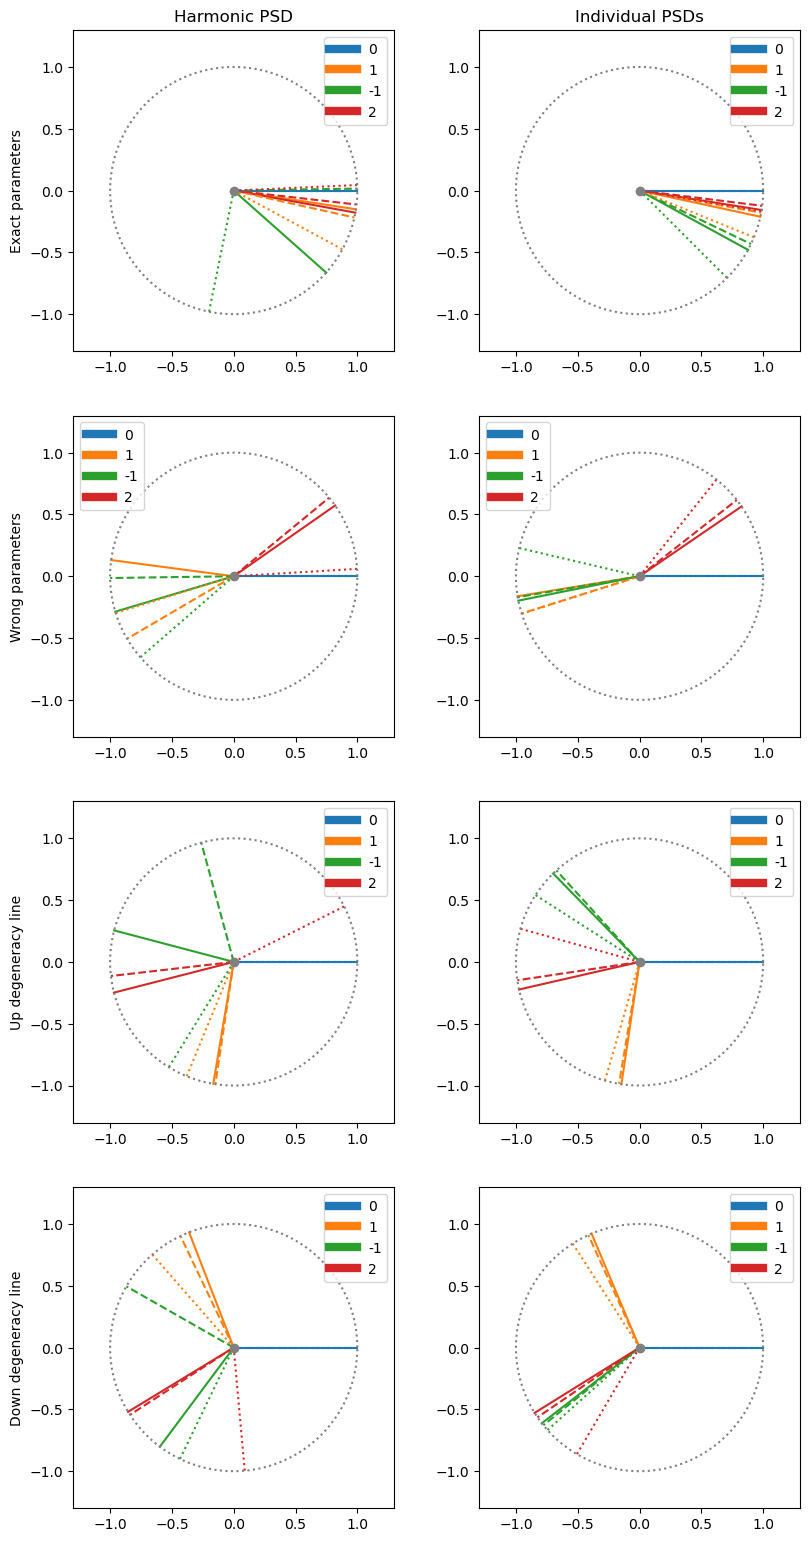

In [24]:
# Plot relative phases of SNRs with both methods
ls = {'H1': 'solid', 'L1': 'dashed', 'V1': 'dotted'}
ylabels = {'on': 'Exact parameters', 'off': 'Wrong parameters', 'up': 'Up degeneracy line', 'down': 'Down degeneracy line'}
plt.figure(figsize=(4.8*2, 4.8*len(wfs.keys())))
for i, wf_key in enumerate(wfs.keys()):
    for ifo in ifos:
    
        # Harmonic PSD
        plt.subplot(len(wfs.keys()), 2, 2*i+1)
        phase_0 = np.angle(SNRs[wf_key]['harm'][ifo][0])
        for j, key in enumerate(SNRs[wf_key]['harm'][ifo].keys()):
            phase = np.angle(SNRs[wf_key]['harm'][ifo][key]) - phase_0
            if ifo == 'H1':
                plt.plot([0,np.cos(phase)], [0, np.sin(phase)], c=f'C{j}', ls=ls[ifo], label=str(key))
            else:
                plt.plot([0,np.cos(phase)], [0, np.sin(phase)], c=f'C{j}', ls=ls[ifo])
        plt.ylabel(ylabels[wf_key])

        # Individual PSDs
        plt.subplot(len(wfs.keys()), 2, 2*i+2)
        phase_0 = np.angle(SNRs[wf_key]['ifo'][ifo][0])
        for j, key in enumerate(SNRs[wf_key]['ifo'][ifo].keys()):
            phase = np.angle(SNRs[wf_key]['ifo'][ifo][key]) - phase_0
            if ifo == 'H1':
                plt.plot([0,np.cos(phase)], [0, np.sin(phase)], c=f'C{j}', ls=ls[ifo], label=str(key))
            else:
                plt.plot([0,np.cos(phase)], [0, np.sin(phase)], c=f'C{j}', ls=ls[ifo])

# Plot formatting
x_titles = {0: 'Harmonic PSD', 1: 'Individual PSDs'}
for i in range(len(wfs.keys())):
    for j in range(2):
        plt.subplot(len(wfs.keys()), 2, 2*i+j+1)
        plt.gca().set_aspect('equal')
        plt.scatter(0, 0, c='gray', zorder=5)
        angs = np.linspace(0, 2*np.pi, 501)
        plt.plot(np.cos(angs), np.sin(angs), c='gray', ls='dotted')
        plt.legend()
        lim = 1.3
        plt.xlim(-lim, lim)
        plt.ylim(-lim, lim)
        if i == 0:
            plt.title(x_titles[j])

In [28]:
# See orthogonality of harmonics in each detector
keys = list(harms_w['harm'].keys())
for ifo in ifos:
    print(ifo)
    for i in range(len(keys)):
        for j in range(i+1,len(keys)):
            zeta = overlap_cplx(
                        harms_w['harm'][keys[i]], harms_w['harm'][keys[j]],
                        psd=psd[ifo], low_frequency_cutoff=10,
                        high_frequency_cutoff=psd[ifo].sample_frequencies[-1],
                        normalized=True
                    )
            print(f'{keys[i]} with {keys[j]}: {np.abs(zeta):.3g}')
    print('')

H1
0 with 1: 0.0152
0 with -1: 0.0263
0 with 2: 0.0024
1 with -1: 0.0055
1 with 2: 0.00145
-1 with 2: 0.000849

L1
0 with 1: 0.0116
0 with -1: 0.0449
0 with 2: 0.00143
1 with -1: 0.00164
1 with 2: 0.00151
-1 with 2: 0.000923

V1
0 with 1: 0.0214
0 with -1: 0.376
0 with 2: 0.0274
1 with -1: 0.0585
1 with 2: 0.102
-1 with 2: 0.0137



In [30]:
harms = make_waveform(params, 1/tlen, f_low, (tlen*sample_rate)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=4, orthonormalize_ecc_harms=True)